### Read in RPi video for led sync test

In [12]:
import os
import numpy as np
import skvideo.io
from glob import glob

base_path = '/n/groups/datta/Jonah/Rpi_test/20210610_rpi'
rpi_vid_path = glob('%s/*.mp4' % base_path )[0]
rpi_vid = skvideo.io.vread(rpi_vid_path, num_frames = 600)

In [13]:
rpi_vid.shape

(600, 972, 1296, 3)

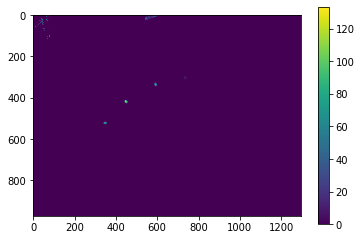

In [22]:
import matplotlib.pyplot as plt
std = np.std(rpi_vid[:,:,:,2], axis=0)
mean = np.mean(rpi_vid[:,:,:,2], axis=0)
plt.imshow(mean)
plt.colorbar()


In [15]:
import skvideo.io
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from skimage.feature import canny

stdpx = np.std(rpi_vid[:,:,:,2], axis=0)

## threshold the image to get rid of edge noise:
thresh = threshold_otsu(stdpx)
thresh_px = np.copy(stdpx)
thresh_px[thresh_px<thresh] = 0

edges = canny(thresh_px/255.) ## find the edges
filled_image = ndi.binary_fill_holes(edges) ## fill its edges
labeled_leds, num_features = ndi.label(filled_image) ## get the clusters

In [43]:
labels = [label for label in np.unique(labeled_leds) if label > 0 ]
            
## get LED x and y positions for sorting
leds_xs = [np.where(labeled_leds==i)[1].mean() for i in labels] 
leds_ys = [np.where(labeled_leds==i)[0].mean() for i in labels] 
sorting = np.argsort(leds_xs)

In [59]:
vid_reader = skvideo.io.FFmpegReader(rpi_vid_path)
(totalFrames, _, _, _) = vid_reader.getShape()
vid_reader.close()
videogen = skvideo.io.vreader(rpi_vid_path)
led_thresh = 50
led_vals = np.zeros((totalFrames,4))
for i,frame in enumerate(videogen):
    for j in range(len(sorting)):
        led_num = sorting[j]
        led_vals[i,j] = frame[round(leds_ys[led_num]).astype('int'), round(leds_xs[led_num]).astype('int'), 2]

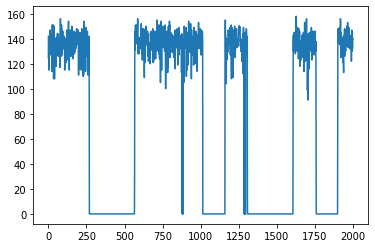

In [65]:
plt.plot(led_vals[0:2000,2])

In [67]:
leds = []
for i in range(4):
    led_vec = np.zeros(totalFrames)
    signal = led_vals[:,i]
    led_on = np.where(np.diff(signal) > led_thresh)[0]   #rise indices
    led_off = np.where(np.diff(signal) < -led_thresh)[0]   #fall indic
    led_vec[led_on] = 1
    led_vec[led_off] = -1
    leds.append(led_vec)
leds = np.vstack(leds) #spiky differenced signals to extract times  

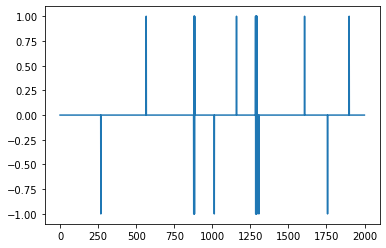

In [72]:
plt.plot(leds[2, 0:2000])

### Get Rpi timestamps

In [254]:
import pandas as pd
rpi_ts_path = '%s/rpicamera_video_timestamps.csv' % base_path
rpi_ts = np.genfromtxt(rpi_ts_path, delimiter=',')
rpi_ts # col 1 is frame times, col 2 is times the rpi recorded itself sending a pulse to Open Ephys

array([[6.00503613e+08, 6.00559320e+08],
       [6.00536943e+08, 6.00576891e+08],
       [6.00570268e+08, 6.00608854e+08],
       ...,
       [2.31054253e+09, 2.31059243e+09],
       [2.31057588e+09, 2.31062577e+09],
       [2.31060918e+09, 2.31065946e+09]])

Text(0, 0.5, 'Difference (sec)')

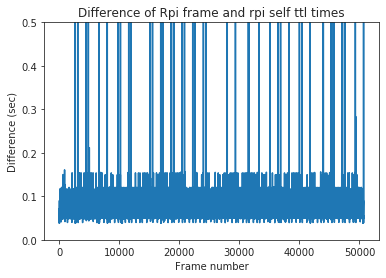

In [255]:
plt.plot(np.diff(rpi_ts, axis=1)/1e6)
plt.ylim((0,0.5)) 
plt.title('Difference of Rpi frame and rpi self ttl times')
plt.xlabel('Frame number')
plt.ylabel('Difference (sec)')

In [256]:
def interpolate_missing_timestamps(ts, fps=30):
    """simple interpolation of missing timestamps (not multiple in a row)
        Taken from Arne's github:
         https://github.com/arnefmeyer/RPiCameraPlugin/blob/master/Python/rpicamera/util.py
    """
    dt = 1. / fps
    missing = np.where(ts < 0)[0]
    for i in missing:

        if i == 0:
            ts[i] = ts[i+1] - dt
        else:
            ts[i] = ts[i-1] + dt

    return ts

Text(0, 0.5, 'Difference (sec)')

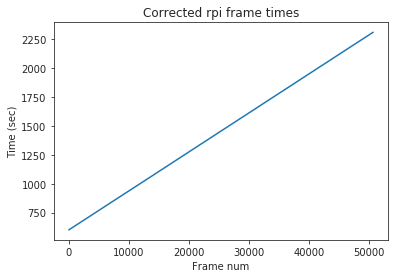

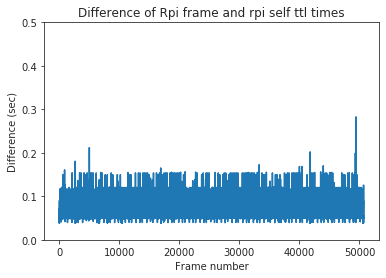

In [257]:
true_fps = totalFrames / (rpi_ts[0,0] - rpi_ts[-1,0])
orig_rpi_ts = rpi_ts.copy()
rpi_ts[:,0] = interpolate_missing_timestamps(rpi_ts[:,0], fps=true_fps)
rpi_ts[:,0] = interpolate_missing_timestamps(rpi_ts[:,0], fps=true_fps)
plt.plot(rpi_ts[:,0]/1e6)
plt.xlabel('Frame num')
plt.ylabel('Time (sec)')
plt.title('Corrected rpi frame times')

plt.figure()
plt.plot(np.diff(rpi_ts, axis=1)/1e6)
plt.ylim((0,0.5)) 
plt.title('Difference of Rpi frame and rpi self ttl times')
plt.xlabel('Frame number')
plt.ylabel('Difference (sec)')

### Use Rpi frame times to generate LED events list (just for sync testing purposes)

In [258]:
from moseq2_ephys_sync.extract_leds import gen_batch_sequence, get_led_data, get_events

rpi_frame_ts = (rpi_ts[:,0] - rpi_ts[0,0]) /1e6 # start at 0 and convert to sec
rpi_self_ttl_ts = (rpi_ts[:,1] - rpi_ts[0,1]) /1e6 
rpi_led_events = get_events(leds, rpi_frame_ts, time_offset=0, num_leds=4)

In [259]:
rpi_led_events

array([[ 3.93265800e+00,  0.00000000e+00,  1.00000000e+00],
       [ 3.93265800e+00,  1.00000000e+00,  1.00000000e+00],
       [ 4.06597100e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.70957233e+03,  3.00000000e+00,  1.00000000e+00],
       [ 1.70957233e+03,  1.00000000e+00,  1.00000000e+00],
       [ 1.70957233e+03,  3.00000000e+00, -1.00000000e+00]])

### Use RPi self ttl times to compare with OE TTL times (general use case)

In [260]:
ephys_fs = 3e4
ephys_ttl_path = glob('%s/**/TTL_*/' % base_path,recursive = True)[0]
channels = np.load('%s/channel_states.npy' % ephys_ttl_path)
ephys_timestamps = np.load('%s/timestamps.npy' % ephys_ttl_path) / ephys_fs # in seconds
print('Assuming rpi ttl is in ttl channel 7...')
rpi_oe_ttl_bool = np.isin(channels, [-7,7])
rpi_oe_ttl_events = np.vstack([ephys_timestamps[rpi_ttl_bool], channels[rpi_ttl_bool], np.sign(channels[rpi_ttl_bool])]).T


Assuming rpi ttl is in ttl channel 7...


In [261]:
# As Arne notes, there are a few extra times in the RPi's file
# See here: https://github.com/arnefmeyer/IMUReaderPlugin
print(rpi_oe_ttl_events[on_bool].shape)
print(rpi_self_ttl_ts.shape)

(50711, 3)
(50714,)


Text(0, 0.5, 'Difference betw RPI and OE TTL trigger times')

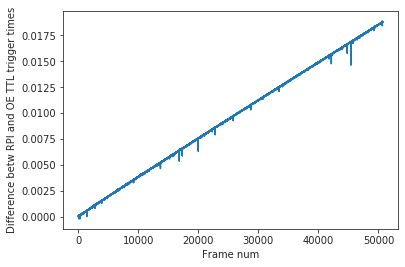

In [262]:
rising_bool = rpi_oe_ttl_events[:,2]==1
zeroed_oe_rpi_ttl = rpi_oe_ttl_events[rising_bool,0] - rpi_oe_ttl_events[0,0]
extra_rpi_ts = rpi_self_ttl_ts.shape[0] - rpi_oe_ttl_events[on_bool].shape[0]
plt.plot(rpi_self_ttl_ts[:(-1*extra_rpi_ts)] - zeroed_oe_rpi_ttl)
plt.xlabel('Frame num')
plt.ylabel('Difference betw RPI and OE TTL trigger times')

Hmm, that's not good. The difference between the RPI and OE TTL trigger times should be flat over the session. If not, there's error accumulating somewhere...20 ms by the end of a 15-min session is large enough that this requires fixing!

### Investigate the drift between RPI and OE TTL

/home/jop9552/miniconda3/envs/sync_test/lib/python3.7/site-packages/ipykernel-6.0.0rc0-py3.7.egg/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


ValueError: operands could not be broadcast together with shapes (316,) (313,) 

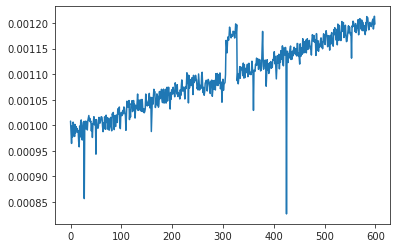

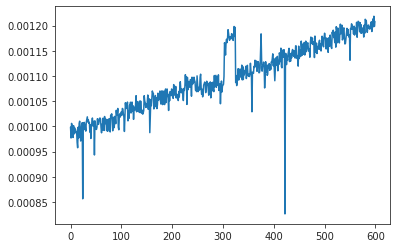

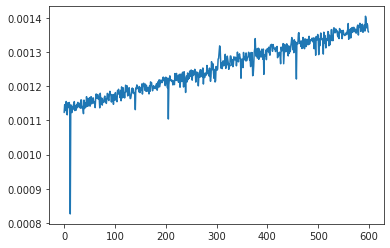

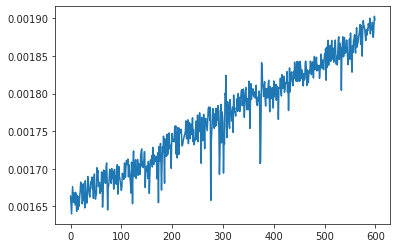

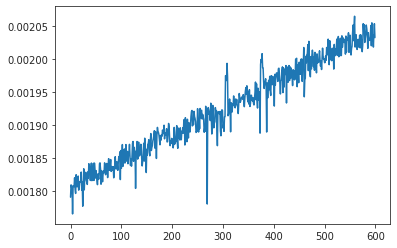

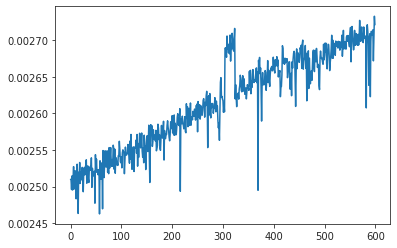

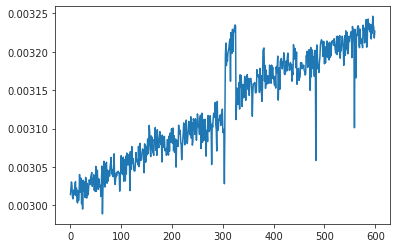

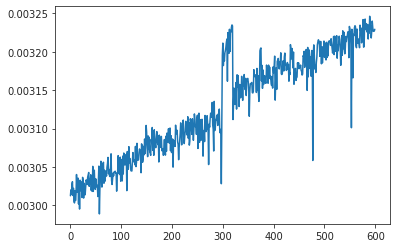

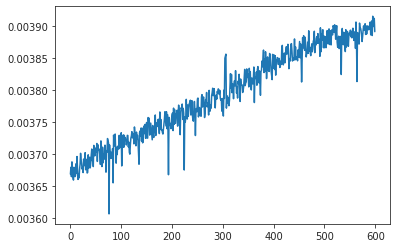

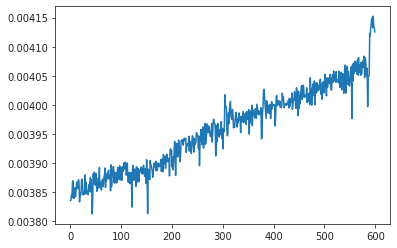

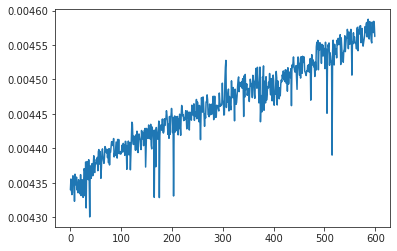

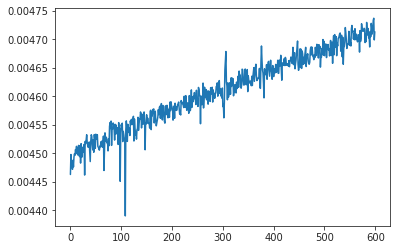

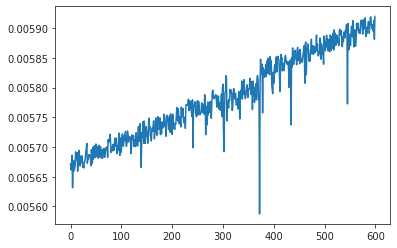

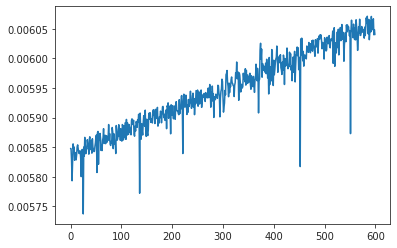

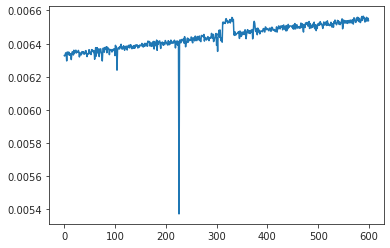

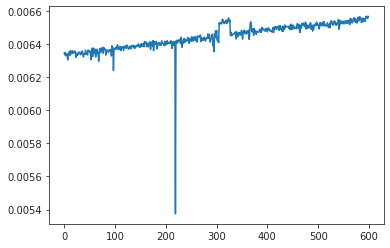

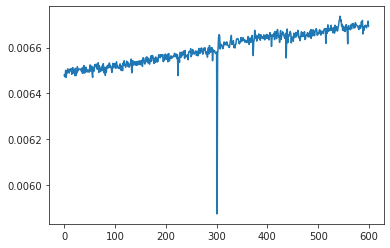

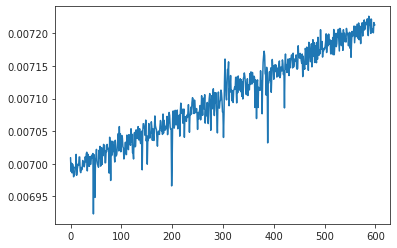

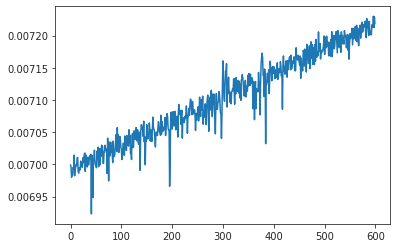

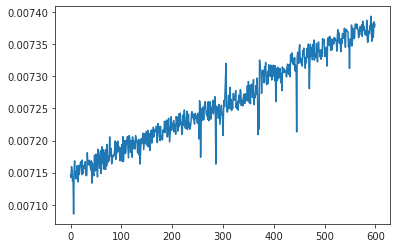

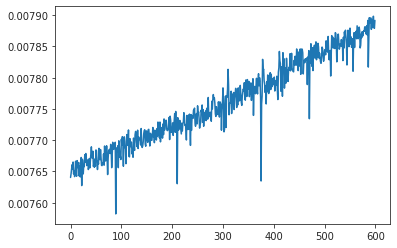

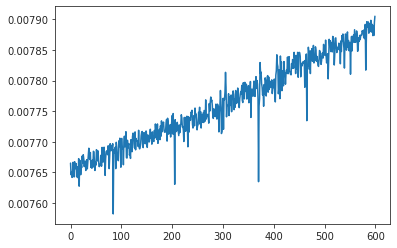

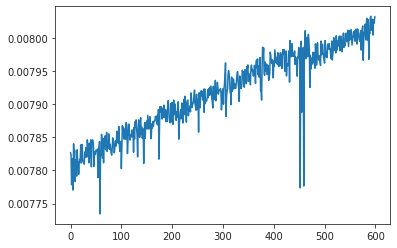

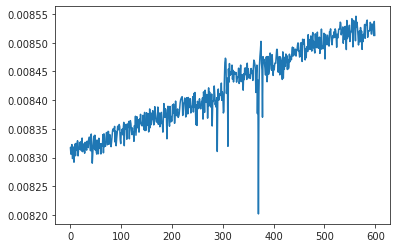

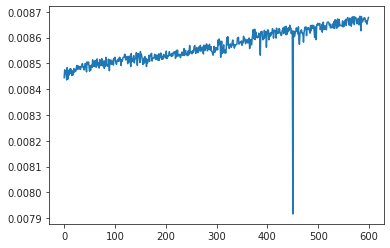

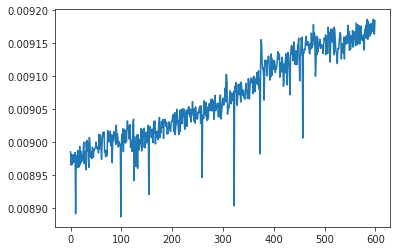

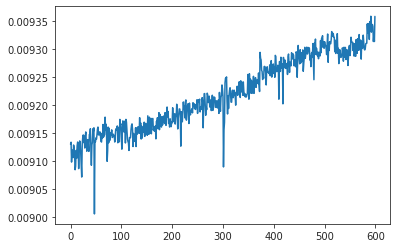

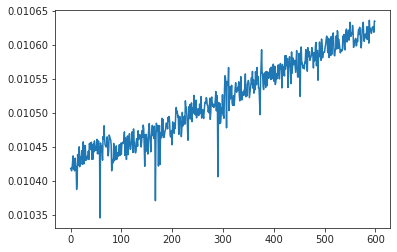

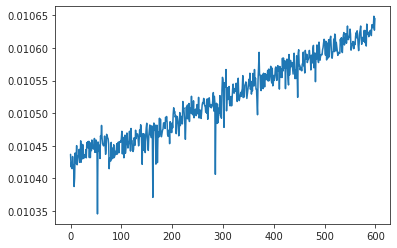

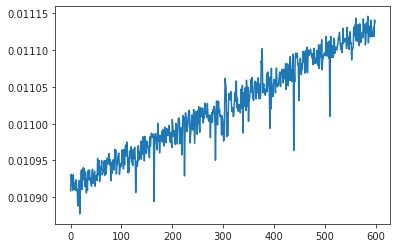

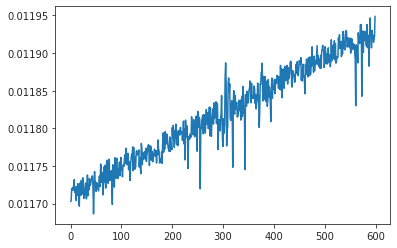

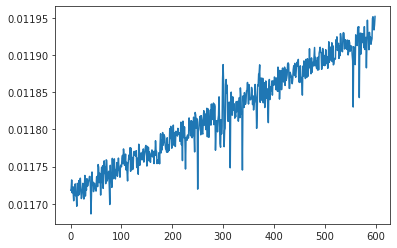

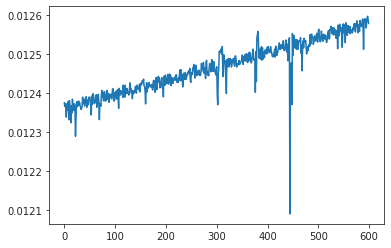

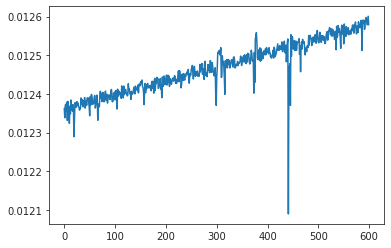

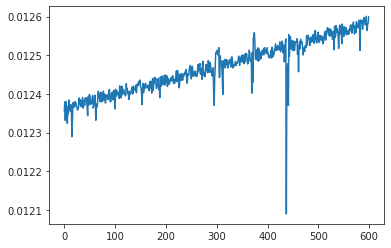

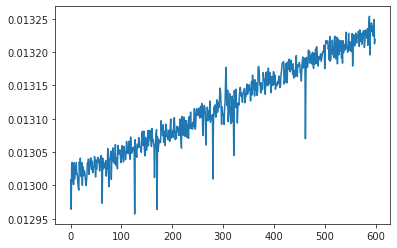

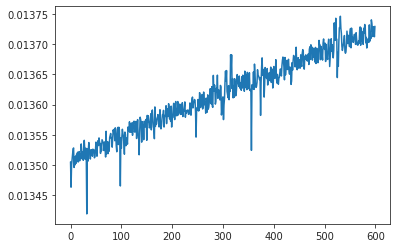

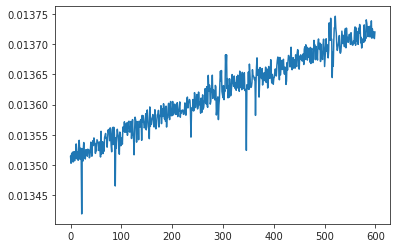

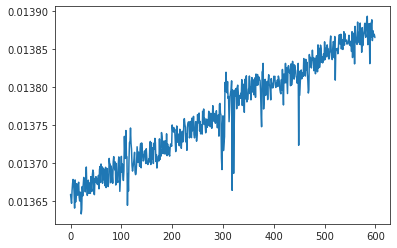

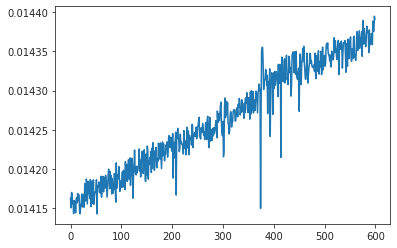

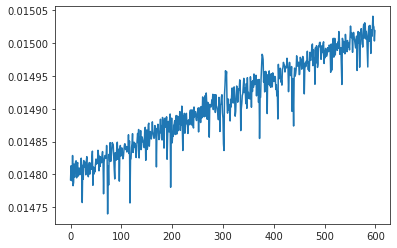

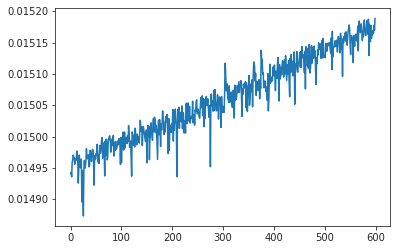

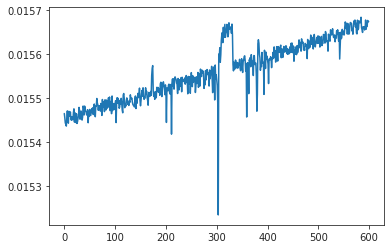

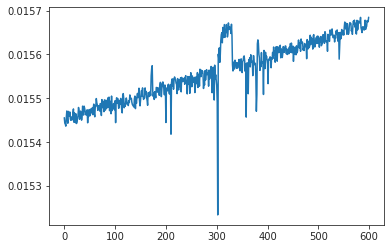

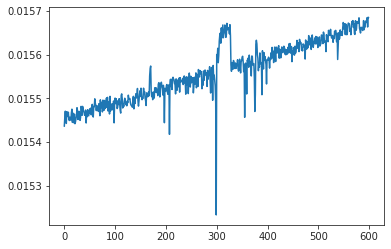

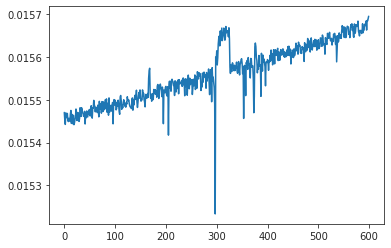

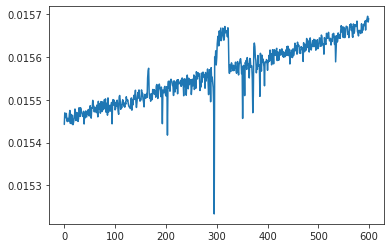

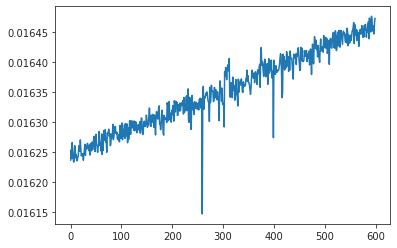

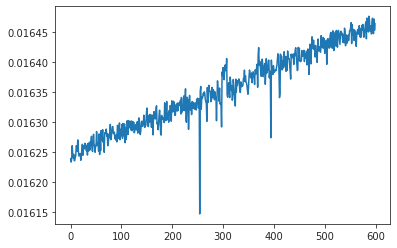

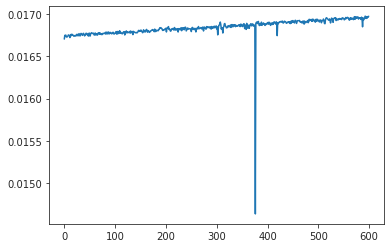

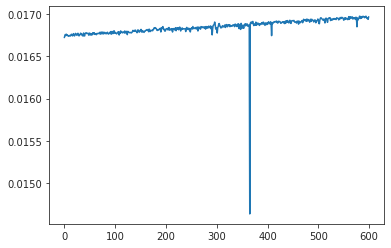

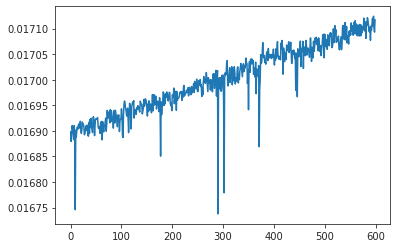

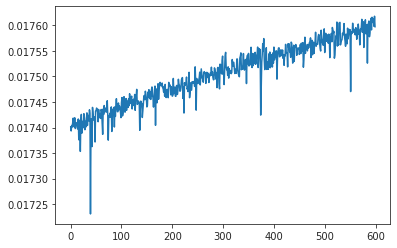

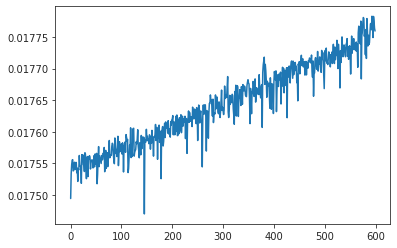

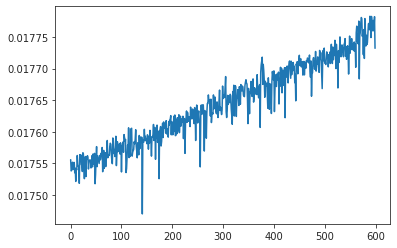

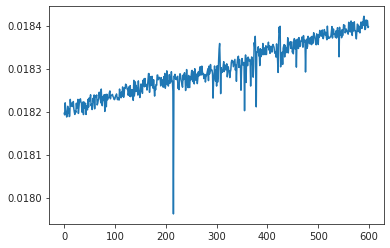

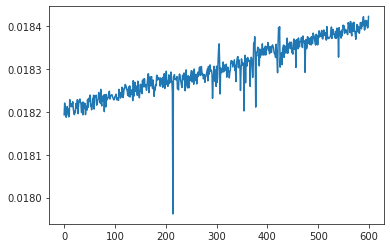

<Figure size 432x288 with 0 Axes>

In [282]:
# Q: Could it be caused by the skipped frames in the RPI?
# A: doesn't look like it. The error is accumulating ms by ms, not stepwise around the dropped frames
skip_idx = np.where(orig_rpi_ts < 0)[0]
for i in range(len(skip_idx)):
    plt.figure()
    slc = slice((skip_idx[i]-300), (skip_idx[i]+300))
    plt.plot(rpi_self_ttl_ts[slc] - zeroed_oe_rpi_ttl[slc])

In [ ]:
plt.close('all')

In [271]:
skip_idx([0]+10)

TypeError: can only concatenate list (not "int") to list

In [200]:
rpi_self_ttl_ts[1:10]

array([0.017571, 0.049534, 0.082633, 0.116187, 0.150714, 0.182535,
       0.216075, 0.249397, 0.282585])

In [201]:
zeroed_oe_rpi_ttl[1:10]

array([0.01743333, 0.0494    , 0.0825    , 0.11603333, 0.15056667,
       0.1824    , 0.21593333, 0.24926667, 0.28243333])

In [202]:
rpi_self_ttl_ts[-10:-1]

array([1709.822199, 1709.83585 , 1709.870393, 1709.903555, 1709.933471,
       1709.966583, 1710.003908, 1710.033113, 1710.066452])

In [203]:
zeroed_oe_rpi_ttl[-10:-1]

array([1709.68523333, 1709.75383333, 1709.78236667, 1709.80336667,
       1709.817     , 1709.8516    , 1709.88476667, 1709.9147    ,
       1709.9478    ])

In [204]:
0.000386583*58

0.022421814

In [205]:
totalFrames

50714